**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [5]:
def drop_irrelevant_columns(df):
    df = df.drop(['saleElapsed', 'kcal_na'], axis=1)
    return df

In [6]:
PATH = "./"

df_raw = pd.read_feather('tmp/lunchbox-raw')

df_raw = drop_irrelevant_columns(df_raw)

df_trn, y_trn, nas = proc_df(df_raw, 'responsevalue')

In [7]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 40 # same as test set sample number
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [8]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [9]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=False)
m.fit(X_train, y_train)
print_score(m)

[0.0, 21.927506626951455, 1.0, -0.35445768336913236]


**- Overfitting exmaple, using the entire Training set**

In [10]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[6.359373533338559, 18.126725779908515, 0.9599480138150428, 0.07439504912144801, 0.7047660772301276]


- as known, 1/3 of samples are NOT used with bootstrap=True (default), so oob_score use that one-third for Validation set

In [13]:
# Comment out this, as our training test is with too few samples!
# Set to 167 (207 train samples (November 18, 2013 to September 30, 2014) - 40 test sample)
set_rf_samples(167)

- Now randomise the same 167 samples from Training set, which is the same size in fact!

In [15]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
# Way too few samples we have, so omit min_samples_leaf=3, max_features=0.5
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[6.377360722933834, 18.24195284913323, 0.9597211230666856, 0.0625899679566182, 0.7184385411663466]


In [16]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=False)
m.fit(X_train, y_train)
print_score(m)

[0.0, 22.029265336138653, 1.0, -0.3670580830310928]


In [17]:
set_rf_samples(110)

In [18]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
# Way too few samples we have, so omit min_samples_leaf=3, max_features=0.5
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[8.981214384833896, 17.869346571013725, 0.9201149494964864, 0.10049354730800386, 0.6873256630937378]


In [19]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=False)
m.fit(X_train, y_train)
print_score(m)

[0.0, 21.974756824593076, 1.0, -0.3603012430015143]


**- Although using randomly chosen samples of 110, fewer than Training set (167), it still use the ENTIRE Training set samples due to bootstrap=False!**

We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [12]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 50.5 ms, sys: 942 µs, total: 51.4 ms
Wall time: 50.7 ms


(57.175, 11.823467131091455)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [13]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 36 ms, sys: 61.3 ms, total: 97.2 ms
Wall time: 115 ms


(57.175, 11.823467131091455)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

In [14]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [15]:
def print_stats(featurename):
    flds = [featurename, 'responsevalue', 'pred', 'pred_std']
    summ = x[flds].groupby(featurename, as_index=False).mean()
    print("*** " + featurename.upper() + " ***")
    print(summ) # Without print(), it won't get printed together with other matplotlib graphs
    print("       ")
    print((summ.pred_std/summ.pred).sort_values(ascending=False))

    x[featurename].value_counts().plot.barh()

    #'~' means negation, the following code gets rid of:
    # NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike entries in 'responsevalue' column
    summ = summ[~pd.isnull(summ.responsevalue)]
    summ.plot(featurename, 'responsevalue', 'barh', xlim=(0,80))

    summ.plot(featurename, 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,100))   

*** WEEK ***
  week  responsevalue       pred   pred_std
0    月         56.125  65.968750   9.055565
1    火         55.250  56.928125   8.342370
2    水         56.125  57.778125  10.731031
3    木         54.500  57.028125   6.478992
4    金         69.250  76.750000  13.915768
       
2    0.185728
4    0.181313
1    0.146542
0    0.137271
3    0.113610
dtype: float64


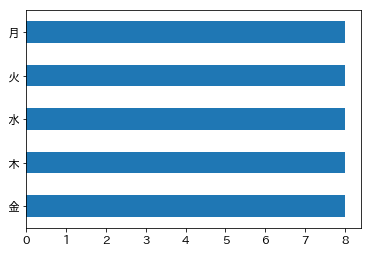

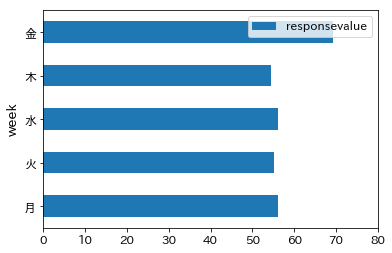

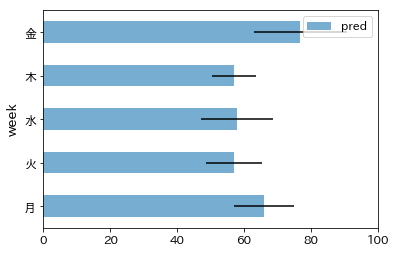

In [16]:
print_stats("week")

*** SOLDOUT ***
   soldout  responsevalue       pred   pred_std
0        0      56.428571  63.094643  10.318336
1        1      62.500000  63.216667  11.612501
       
1    0.183694
0    0.163537
dtype: float64


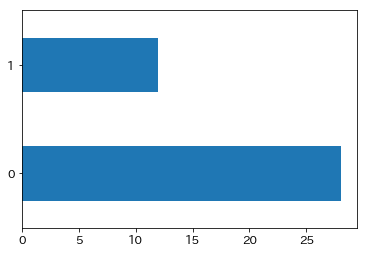

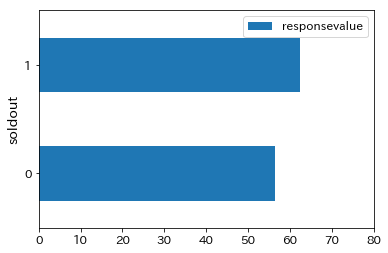

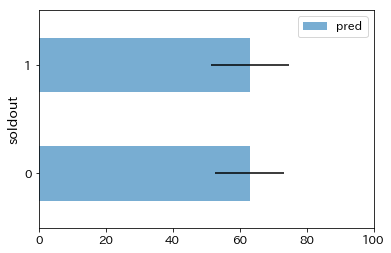

In [14]:
print_stats("soldout")

*** NAME ***
                 name  responsevalue    pred   pred_std
0               いか天ぷら            NaN     NaN        NaN
1             かじきの甘辛煮            NaN     NaN        NaN
2         きのこソースハンバーグ            NaN     NaN        NaN
3           さっくりメンチカツ            NaN     NaN        NaN
4            さわら焼味噌掛け            NaN     NaN        NaN
5              さんま辛味焼            NaN     NaN        NaN
6         たっぷりベーコンフライ            NaN     NaN        NaN
7    ひやしたぬきうどん・炊き込みご飯            NaN     NaN        NaN
8         ぶりレモンペッパー焼き           54.0  56.800   7.778817
9         ますのマスタードソース            NaN     NaN        NaN
10      やわらかロースのサムジョン            NaN     NaN        NaN
11         アジ唐揚げ南蛮ソース            NaN     NaN        NaN
12              エビフライ            NaN     NaN        NaN
13          カキフライタルタル            NaN     NaN        NaN
14            カレイの唐揚げ           62.0  57.625   8.257383
15        カレイ唐揚げ 甘酢あん           46.0  55.725   5.549718
16        カレイ唐揚げ夏野菜あん            Na

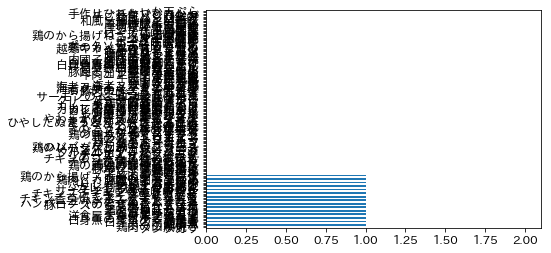

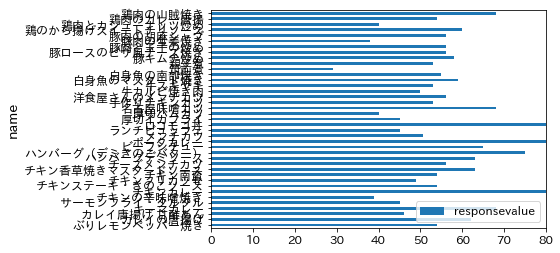

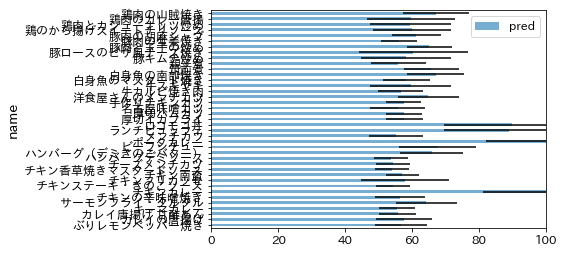

In [17]:
print_stats("name")

- NaN means name exists on training set, but NOT in validation set we set aside i.e., the last 40 samples of test set 

*** KCAL ***
    kcal  responsevalue       pred   pred_std
0    380      48.666667  58.883333   7.049319
1    385      58.000000  61.375000   9.136654
2    386      60.000000  59.950000  11.749362
3    394      50.000000  56.575000   6.815011
4    395      37.500000  60.712500   6.864786
5    396      56.000000  63.062500   8.242702
6    398      39.500000  57.900000   9.849722
7    400      51.750000  57.606250   7.375384
8    404      56.000000  65.150000   6.747407
9    405      54.000000  55.600000   5.000003
10   408      83.500000  84.187500  17.325442
11   410      65.000000  60.558333  10.349220
12   411      45.000000  64.300000   9.075241
13   412      55.000000  67.075000   8.474631
14   415      63.000000  54.075000   5.071427
15   423      56.000000  60.375000  16.196740
16   430      49.000000  57.925000  13.054477
17   438      56.000000  54.300000   5.065570
18   440      68.000000  55.650000   8.162567
19   441      58.000000  57.175000  11.823467
20   450      54.0000

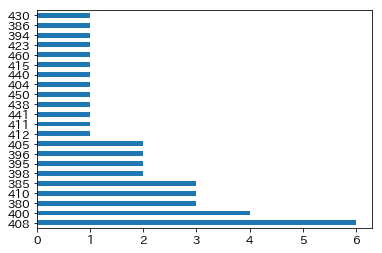

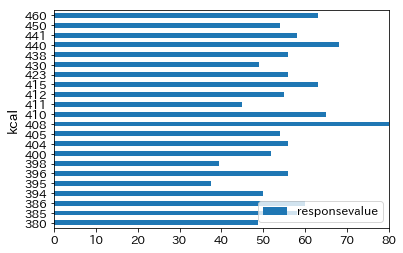

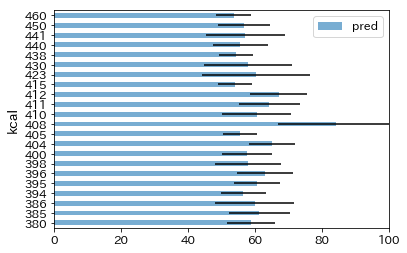

In [18]:
print_stats("kcal")

*** REMARKS ***
                    remarks  responsevalue        pred   pred_std
0                        NA      53.575758   59.112879   7.943962
1                  お楽しみメニュー     114.666667  100.625000  22.984154
2           スペシャルメニュー（800円）      45.000000   89.075000  19.672808
3                     手作りの味      68.000000   55.650000   8.162567
4              料理長のこだわりメニュー      52.500000   59.150000  14.625608
5          酢豚（28食）、カレー（85食）            NaN         NaN        NaN
6  鶏のレモンペッパー焼（50食）、カレー（42食）            NaN         NaN        NaN
       
4    0.247263
1    0.228414
2    0.220857
3    0.146677
0    0.134386
5         NaN
6         NaN
dtype: float64


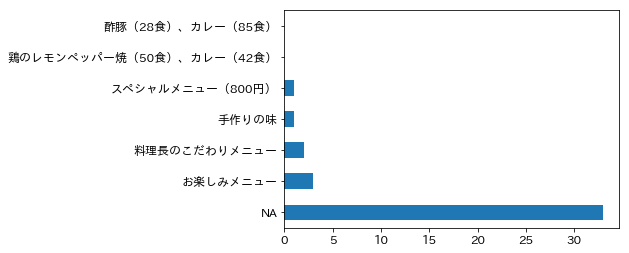

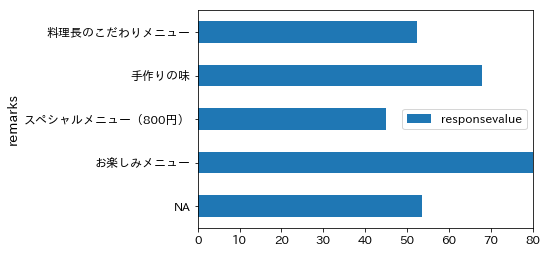

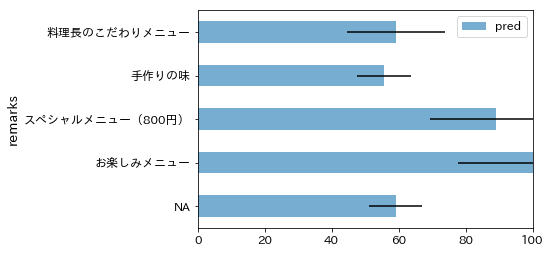

In [19]:
print_stats("remarks")

*** EVENT ***
           event  responsevalue       pred   pred_std
0             NA      59.055556  62.534722   9.287119
1  キャリアアップ支援セミナー      49.500000  73.037500  12.301156
2           ママの会      52.500000  59.150000  14.625608
       
2    0.247263
1    0.168422
0    0.148511
dtype: float64


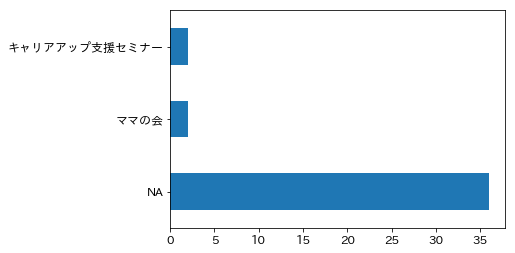

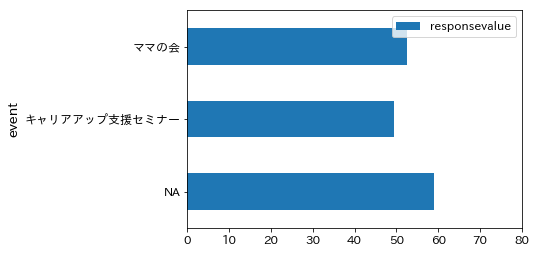

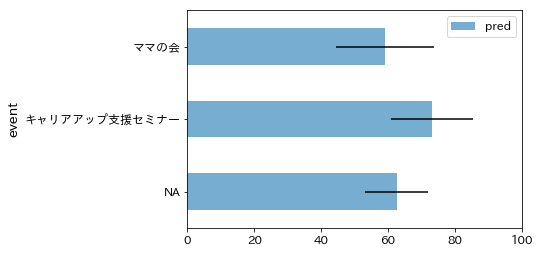

In [20]:
print_stats("event")

*** PAYDAY ***
   payday  responsevalue       pred   pred_std
0   False           56.5  61.931579   9.376450
1    True           91.5  81.112500  15.942358
       
1    0.196546
0    0.151400
dtype: float64


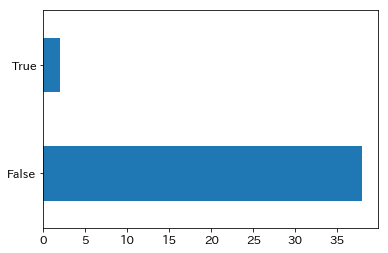

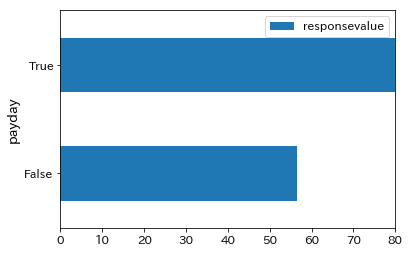

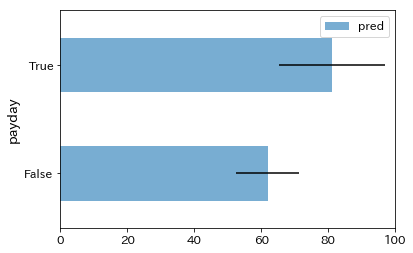

In [21]:
print_stats("payday")

*** WEATHER ***
  weather  responsevalue       pred   pred_std
0      快晴      52.800000  60.560000  12.351559
1      晴れ      61.384615  66.384615  11.174270
2       曇      60.437500  62.804688   9.206243
3      薄曇      45.666667  56.900000   5.272322
4       雨      54.666667  58.083333   6.016548
5       雪            NaN        NaN        NaN
6      雷電            NaN        NaN        NaN
       
0    0.203956
1    0.168326
2    0.146585
4    0.103585
3    0.092659
5         NaN
6         NaN
dtype: float64


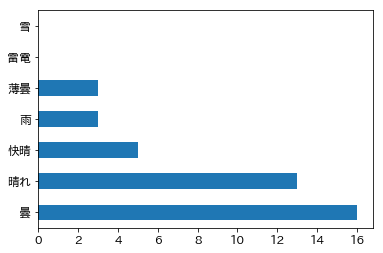

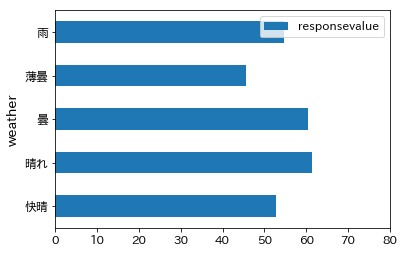

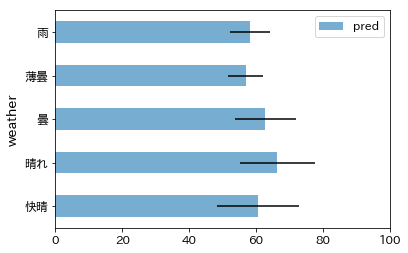

In [22]:
print_stats("weather")

*** PRECIPITATION ***
   precipitation  responsevalue       pred  pred_std
0            0.0          58.25  62.890625  9.704745
       
0    0.154311
dtype: float64


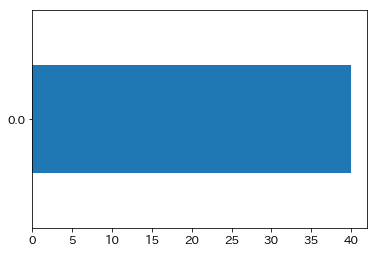

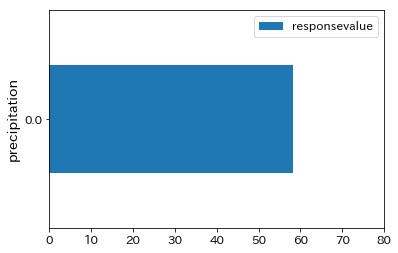

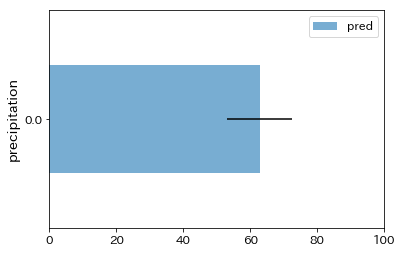

In [23]:
print_stats("precipitation")

*** TEMPERATURE ***
    temperature  responsevalue      pred   pred_std
0          21.0           62.0   57.6250   8.257383
1          21.6           56.0   61.2250   7.312618
2          21.9           53.0   57.4750   5.333796
3          23.1           68.0   67.0500   9.906942
4          23.4           65.0   67.6750  11.507362
5          23.6           45.0   57.7250   5.495396
6          24.1           46.0   55.7250   5.549718
7          24.8           59.0   58.3250   7.079504
8          25.0           51.5   57.3625  10.416647
9          25.1           39.0   56.3500   7.564886
10         25.2           29.0   65.7000   8.179853
11         25.4           50.0   56.5750   6.815011
12         26.0           55.0   67.0750   8.474631
13         26.2           68.0   55.5750   5.366039
14         26.5           54.0   54.2000   5.070503
15         26.6           56.0   65.1500   6.747407
16         26.7           53.0   55.8500   8.247879
17         26.8           63.0   53.7250   5

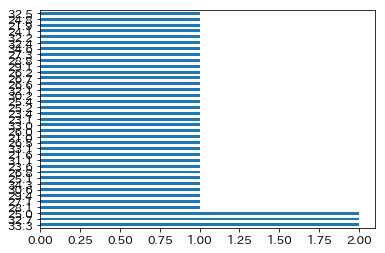

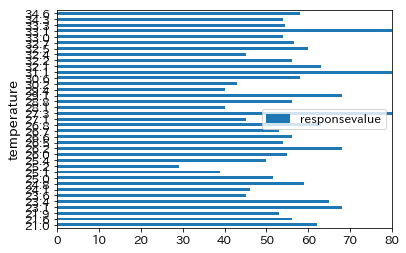

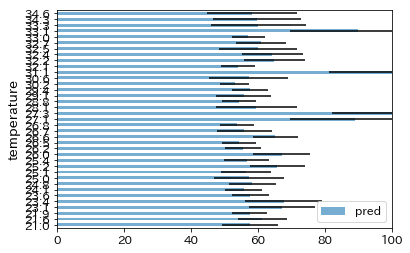

In [24]:
print_stats("temperature")

In [25]:
display_all(x)

,responsevalue,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,kcal_na,pred_std,pred
167,58,水,0,メンチカツ,441,NA,NA,False,晴れ,0.0,30.6,2014,7,31,30,2,211,False,False,False,False,False,False,1406678400,False,11.823467,57.175
168,60,木,0,鶏のから揚げスイートチリソース,386,NA,NA,False,晴れ,0.0,32.5,2014,7,31,31,3,212,True,False,False,False,False,False,1406764800,False,11.749362,59.950
169,38,金,0,豚肉の生姜焼き,380,NA,NA,False,薄曇,0.0,32.7,2014,8,31,1,4,213,False,True,False,False,False,False,1406851200,False,5.392066,55.975
170,75,月,1,ハンバーグ（デミきのこバター）,410,NA,NA,False,曇,0.0,32.7,2014,8,32,4,0,216,False,False,False,False,False,False,1407110400,False,9.380299,65.900
171,54,火,1,鶏肉のカレー唐揚,400,NA,NA,False,快晴,0.0,34.3,2014,8,32,5,1,217,False,False,False,False,False,False,1407196800,False,13.269114,59.675
172,58,水,1,豚キムチ炒め,410,NA,NA,False,快晴,0.0,34.6,2014,8,32,6,2,218,False,False,False,False,False,False,1407283200,False,13.409978,58.150
173,63,木,0,チキン香草焼きマスタードソース,415,NA,NA,False,晴れ,0.0,32.1,2014,8,32,7,3,219,False,False,False,False,False,False,1407369600,False,5.071427,54.075
174,129,金,0,チキンカレー,408,お楽しみメニュー,NA,True,曇,0.0,31.1,2014,8,32,8,4,220,False,False,False,False,False,False,1407456000,True,24.105899,105.425
175,45,月,0,サーモンフライ・タルタル,411,NA,NA,False,晴れ,0.0,32.4,2014,8,33,11,0,223,False,False,False,False,False,False,1407715200,False,9.075241,64.300
176,40,火,1,厚切ハムカツ,400,NA,NA,False,雨,0.0,29.4,2014,8,33,12,1,224,False,False,False,False,False,False,1407801600,False,5.370987,57.450


*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [38]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
9,temperature,0.553621
15,saleDayofyear,0.139883
3,kcal,0.050807
13,saleDay,0.044100
14,saleDayofweek,0.040905
0,week,0.038207
2,name,0.030993
4,remarks,0.029417
12,saleWeek,0.027598
7,weather,0.013977


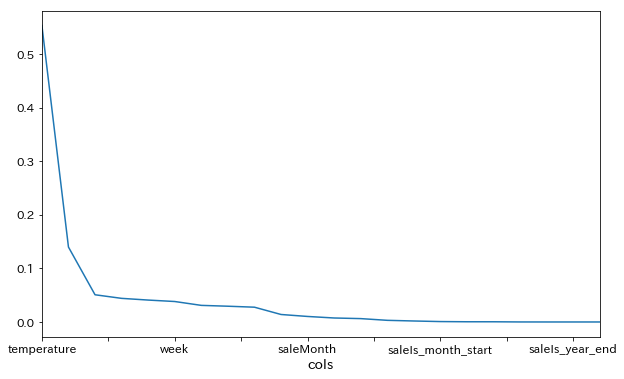

In [39]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [40]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

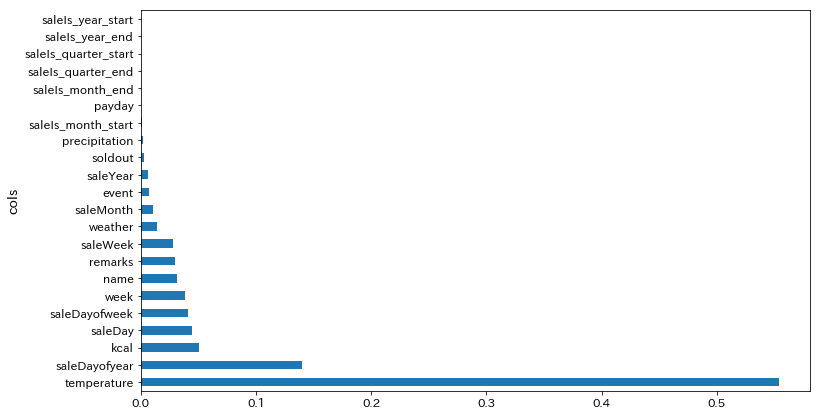

In [41]:
plot_fi(fi[:30]);

In [42]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)

11

In [43]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [44]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
#                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[6.043350752964227, 17.09230821159038, 0.9638297933549614, 0.17702172611711675, 0.7351223799124011]


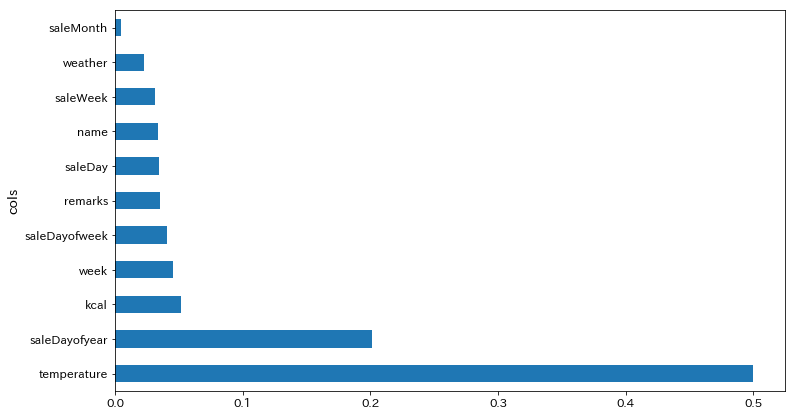

In [45]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [46]:
df_trn2, y_trn, nas = proc_df(df_raw, 'responsevalue', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[6.307674313050806, 12.192975052258575, 0.9605965807319718, 0.5812003503644495, 0.7303449918849643]


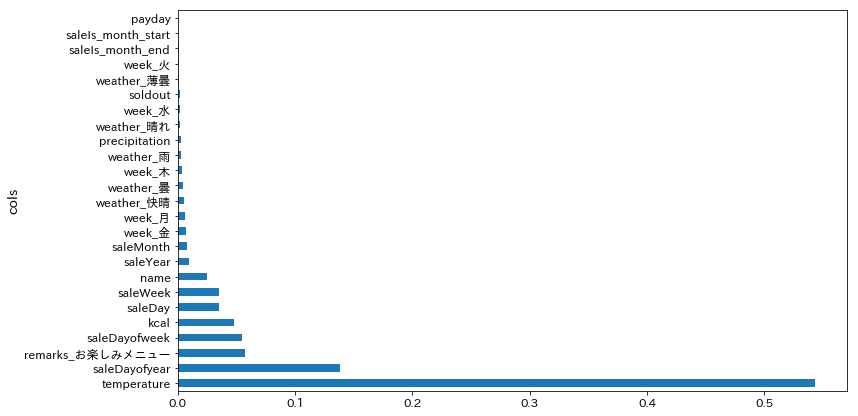

In [47]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [48]:
from scipy.cluster import hierarchy as hc

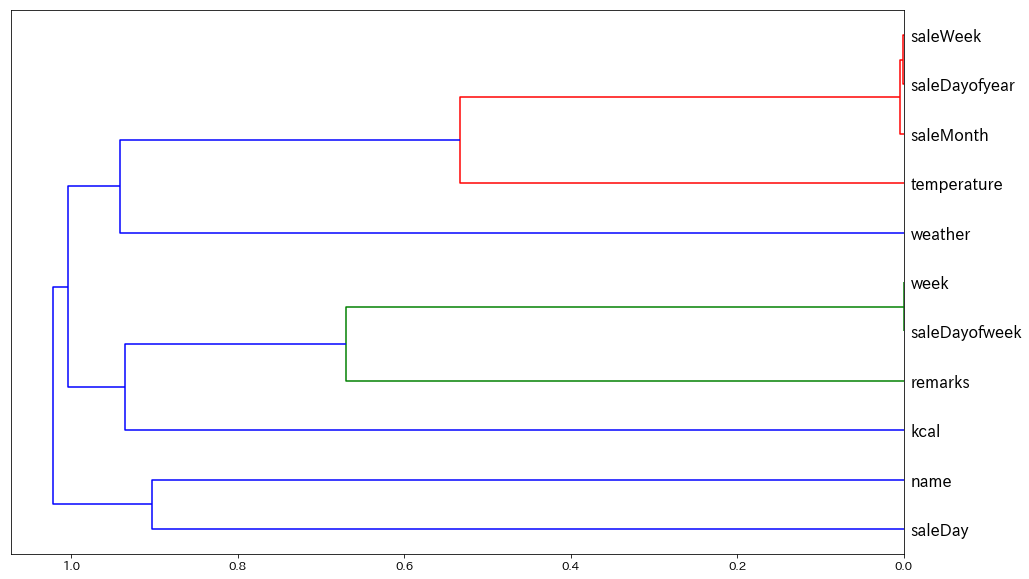

In [49]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [50]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, n_jobs=-1, oob_score=True)
    #m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [51]:
get_oob(df_keep)

0.6859672302808638

Now we try removing each variable one at a time.

In [52]:
for c in ('temperature', 'saleDayofyear', 'week', 'saleDay', 'saleDayofweek', 'saleWeek', 'kcal', 'name', 'saleWeek', 'weather'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

temperature 0.761585140425538
saleDayofyear 0.7224682717665013
week 0.7005641687551072
saleDay 0.7018719973924539
saleDayofweek 0.7268186277080699
saleWeek 0.6957488165691301
kcal 0.7242432038822176
name 0.723265894974053
saleWeek 0.7168491108142387
weather 0.6921314406859502


In [58]:
# Remove name (0.7410925045497967) and weather (0.7782008000884504), both better than 0.7715382548450727
to_drop = ['temperature']
get_oob(df_keep.drop(to_drop, axis=1))

0.7249360497591375

It looks like we can try one from each group for removal. Let's see what that does.

In [55]:
# This time, remove redundnat fields from the above dendrogram
to_drop = ['saleDayofweek', 'saleDayofyear']
get_oob(df_keep.drop(to_drop, axis=1))

0.7207034489559607

In [56]:
# This time, combine all the above, 5 of them
to_drop = ['name', 'weather', 'saleDayofweek', 'saleDayofyear']
get_oob(df_keep.drop(to_drop, axis=1))

0.7247874747961274

In [57]:
# This time, combine all the above, 5 of them
to_drop = ['name', 'weather']
get_oob(df_keep.drop(to_drop, axis=1))

0.7047129310205623

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [59]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [60]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [61]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [62]:
#Comment this out, as we never use 'set_rf_samples'
#reset_rf_samples()

In [63]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[6.293211400432924, 17.569819204391376, 0.9607770703486019, 0.13039600866227685, 0.732572214953388]


# Partial dependence

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

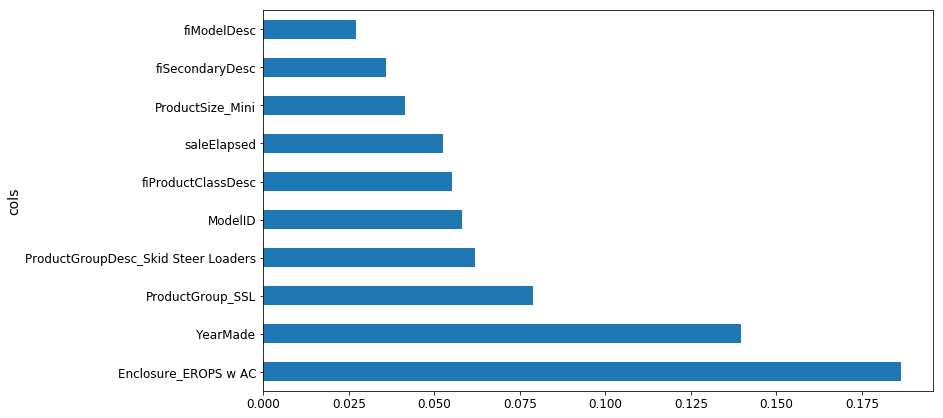

In [ ]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

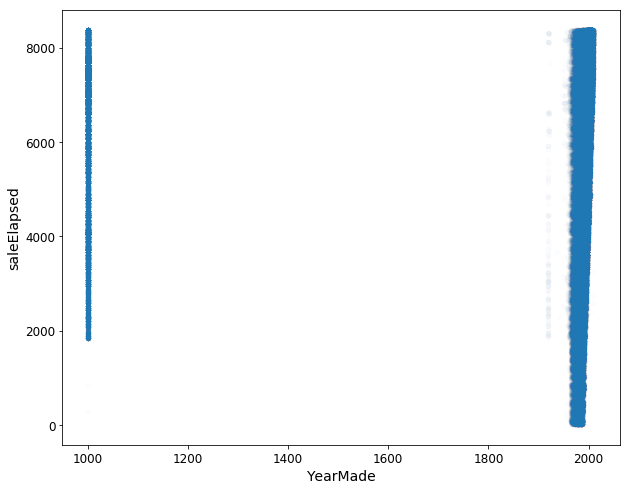

In [ ]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

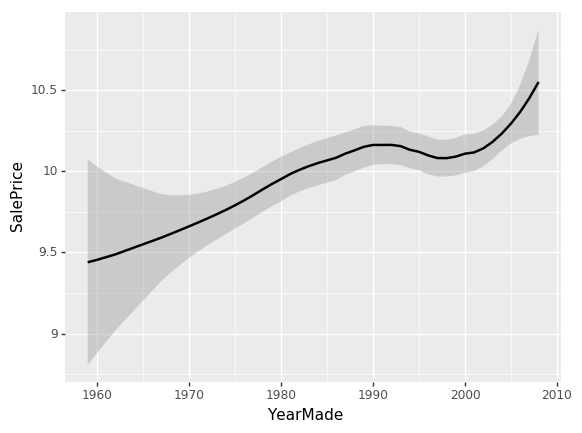

<ggplot: (8729550331912)>

In [ ]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

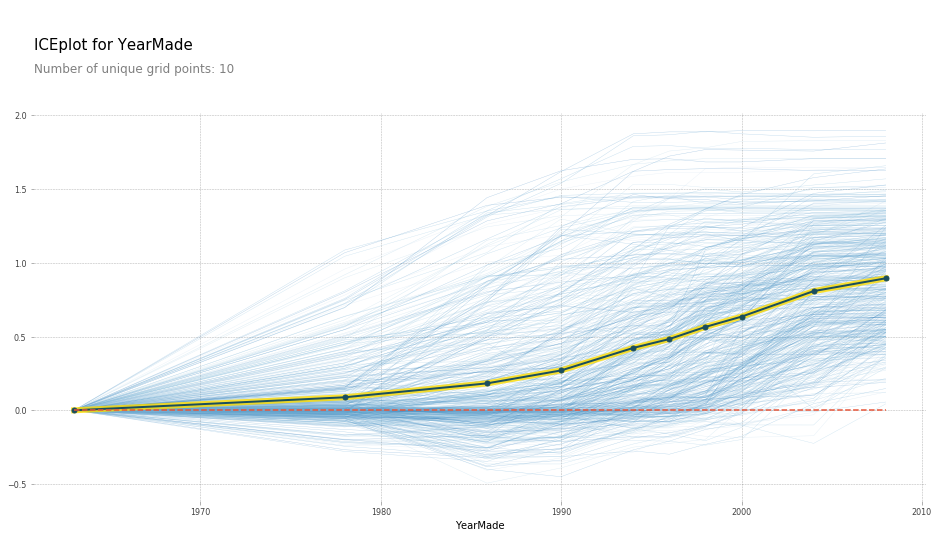

In [ ]:
plot_pdp('YearMade')

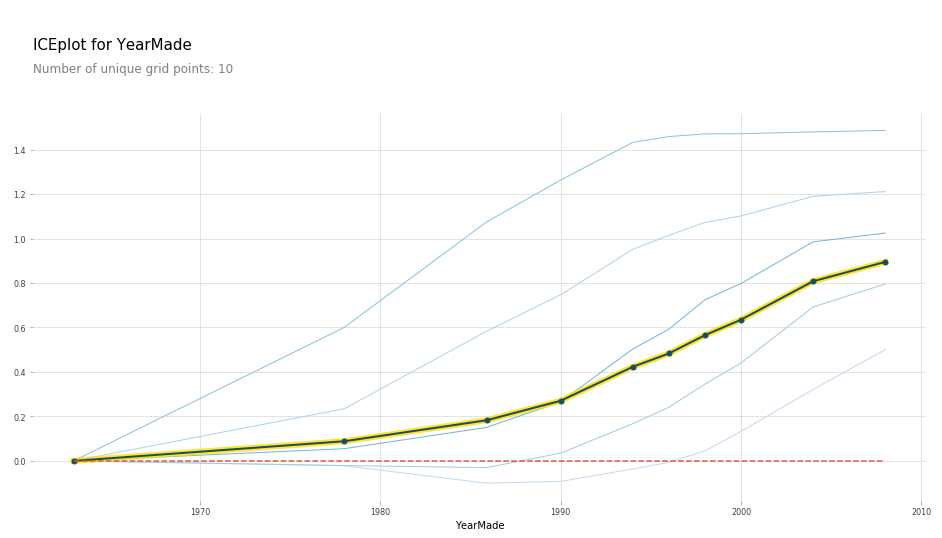

In [ ]:
plot_pdp('YearMade', clusters=5)

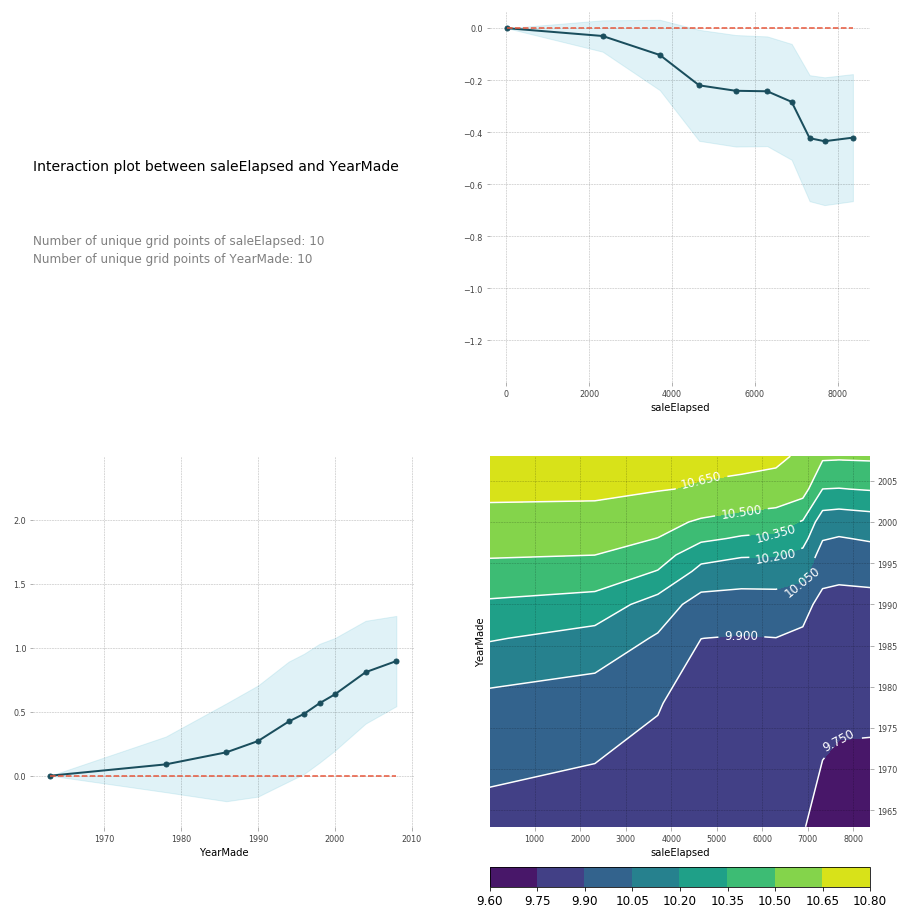

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

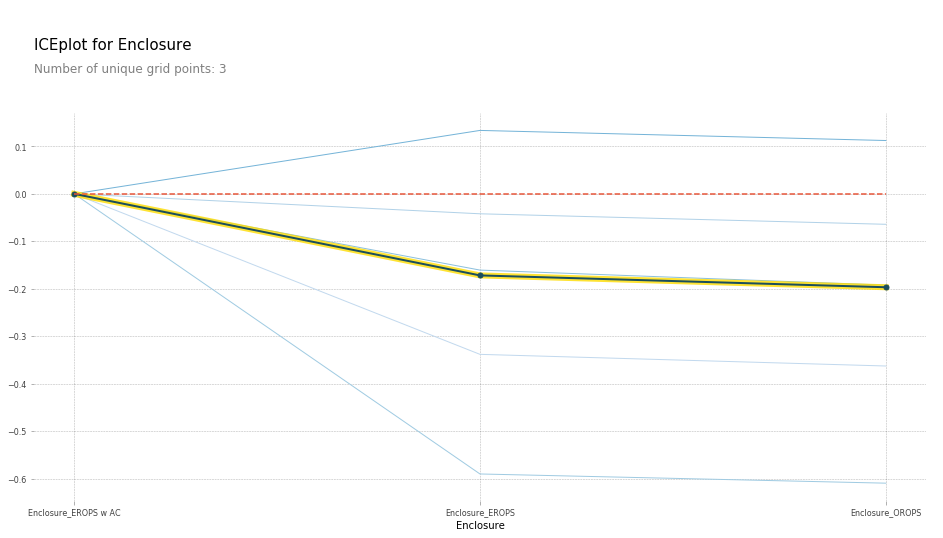

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

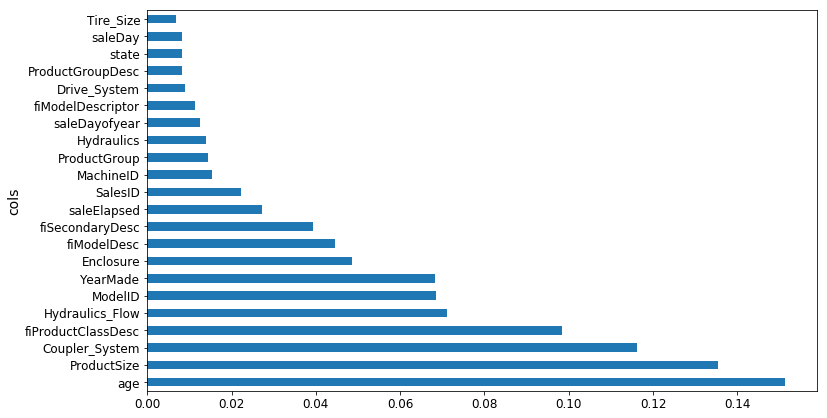

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 3, 3232, 1111, 0, 63, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9, 37,
        16, 3, 259, False, False, False, False, False, False, 7912, False, False]], dtype=object)

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

(9.1909688098736275, 10.10606580677884)

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54680742853695008),
 ('age', 11, -0.12507089451852943),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
 ('fiModelDesc', 'KX1212', -0.065155113754146801),
 ('fiSecondaryDesc', nan, -0.055237427792181749),
 ('Enclosure', 'EROPS', -0.050467175593900217),
 ('fiModelDescriptor', nan, -0.042354676935508852),
 ('saleElapsed', 7912, -0.019642242073500914),
 ('saleDay', 16, -0.012812993479652724),
 ('Tire_Size', nan, -0.0029687660942271598),
 ('SalesID', 4364751, -0.0010443985823001434),
 ('saleDayofyear', 259, -0.00086540581130196688),
 ('Drive_System', nan, 0.0015385818526195915),
 ('Hydraulics', 'Standard', 0.0022411701338458821),
 ('state', 'Ohio', 0.0037587658190299409),
 ('ProductGroupDesc', 'Track Excavators', 0.0067688906745931197),
 ('ProductGroup', 'TEX', 0.014654732626326661),
 ('MachineID', 2300944, 0.015578052196894499),
 ('Hydraulics_Flow', nan, 0.028973749866174004),
 ('ModelID', 665, 0.0383074

In [ ]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [64]:
??proc_df

In [54]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/home/to/miniconda3/envs/signate/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
#m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9951690821256038

In [56]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,saleElapsed,0.564664
3,saleDayofyear,0.187495
8,saleWeek,0.171170
1,temperature,0.060674
7,kcal,0.012476
4,saleDay,0.002268
5,week,0.001252
2,kcal_na,0.000000
6,saleDayofweek,0.000000


In [57]:
feats=['saleElapsed', 'saleDayofyear', 'saleWeek']

In [58]:
X_train[feats].describe()

,saleElapsed,saleDayofyear,saleWeek
count,1.670000e+02,167.000000,167.000000
mean,1.395889e+09,147.323353,21.874251
std,6.368506e+06,102.394658,14.586749
min,1.384733e+09,7.000000,2.000000
25%,1.390824e+09,67.500000,10.500000
50%,1.395965e+09,132.000000,20.000000
75%,1.401365e+09,189.500000,28.000000
max,1.406592e+09,360.000000,52.000000


In [59]:
X_valid[feats].describe()

,saleElapsed,saleDayofyear,saleWeek
count,4.000000e+01,40.000000,40.000000
mean,1.409355e+09,241.975000,35.425000
std,1.597994e+06,18.495304,2.649504
min,1.406678e+09,211.000000,31.000000
25%,1.408190e+09,228.500000,33.750000
50%,1.409400e+09,242.500000,35.500000
75%,1.410566e+09,256.000000,37.250000
max,1.412035e+09,273.000000,40.000000


In [60]:
x.drop(feats, axis=1, inplace=True)

In [61]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
#m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.855072463768116

In [62]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,temperature,0.485389
5,kcal,0.255451
2,saleDay,0.168815
4,saleDayofweek,0.039778
3,week,0.039154
1,kcal_na,0.011412


In [110]:
# If we are to use oob_score, we cannot use set_rf_samples!
# Set to 167 (207 samples (November 18, 2013 to September 30, 2014) - 40 test set sie)
#set_rf_samples(167)

In [114]:
feats=['temperature', 'kcal', 'saleDay']

In [63]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[5.627393037207334, 13.240423426008702, 0.9686375569782273, 0.5061549702454311, 0.7668828802573864]


In [64]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

saleElapsed
[9.727643389942676, 14.966042033533887, 0.9062846632727748, 0.3690414052621483, 0.77273202841696]
saleDayofyear
[10.018484411474658, 16.053015710748753, 0.9005970115833326, 0.2740608798632451, 0.7665195220058407]
saleWeek
[9.61755882023139, 14.653908722557487, 0.9083937532624181, 0.39508562738393216, 0.7617885918095494]


In [67]:
#reset_rf_samples()

In [68]:
df_subs = df_keep.drop(['saleElapsed', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[6.026708270262491, 13.360258231037301, 0.9640287337131634, 0.4971752526497413, 0.7517108798157371]


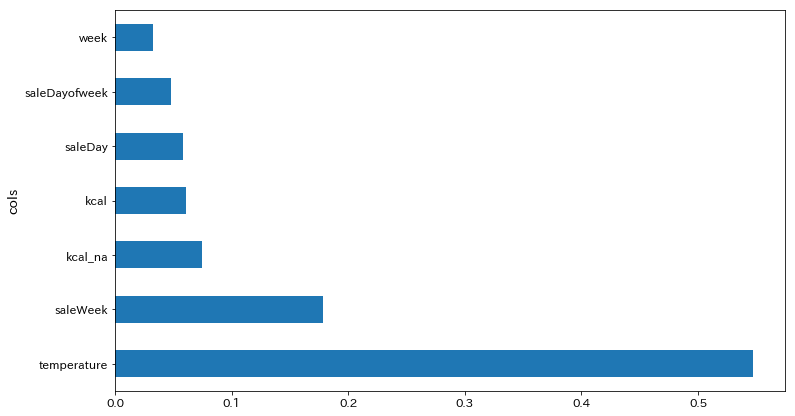

In [69]:
plot_fi(rf_feat_importance(m, X_train));

In [70]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [71]:
m = RandomForestRegressor(n_estimators=160, n_jobs=-1, oob_score=True)
#m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 250 ms, sys: 36.7 ms, total: 287 ms
Wall time: 207 ms
[5.392777161939692, 13.380184560281204, 0.9711981531081809, 0.49567424524190984, 0.782349184940814]


In [ ]:
predict(X_valid)